## yelpReviewsTopicModelling

In [1]:
## IMPORT NECESSARY PACKAGES #1

from pprint import pprint
# import pandasql as ps
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from zipfile import ZipFile
from io import BytesIO
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display, HTML
# InteractiveShell.ast_node_interactivity = "all"
# CSS = """
# .output {
#     flex-direction: row;
# }
# """
# HTML('<style>{}</style>'.format(CSS))

sns.set()

In [2]:
## LOAD TORONTO DATASETS & DELETE WEIRD 

restaurants_df = pd.read_csv("datasets/american_restaurants.csv", sep='\t', encoding='utf-8')
reviews_df = pd.read_csv("datasets/review_sentiment.csv", encoding='utf-8')

del(restaurants_df['Unnamed: 0'])
# del(reviews_df['Unnamed: 0'])

restaurants_df = restaurants_df[restaurants_df['RestaurantsPriceRange2'] == 2]
reviews_df = reviews_df.loc[reviews_df['business_id'].isin(restaurants_df.business_id)]

In [3]:
restaurants_df.head()

,address,attributes,AcceptsInsurance,AgesAllowed,Alcohol,Ambience,BYOB,BYOBCorkage,BestNights,BikeParking,...,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state,cuisine
0,2201 S Fort Apache Rd,NaN,NaN,NaN,full_bar,"{'romantic': False, 'intimate': False, 'classy...",NaN,NaN,NaN,True,...,1,36.147496,-115.298066,Chicago Brewing Company,Westside,89117.0,446,3.5,NV,american
4,"7160 North Durango Dr, Ste 110",NaN,NaN,NaN,beer_and_wine,"{'romantic': False, 'intimate': False, 'classy...",NaN,NaN,NaN,True,...,0,36.291436,-115.287016,Table 89,Centennial,89149.0,79,3.5,NV,american
5,6689 Las Vegas Blvd,NaN,NaN,NaN,beer_and_wine,"{'romantic': False, 'intimate': False, 'classy...",NaN,NaN,NaN,True,...,1,36.067581,-115.174230,LV bar,Southeast,89119.0,22,4.5,NV,american
6,6683 Las Vegas Blvd S,NaN,NaN,NaN,full_bar,"{'romantic': False, 'intimate': False, 'classy...",NaN,NaN,"{'monday': True, 'tuesday': False, 'friday': T...",True,...,1,36.066182,-115.175288,Miller's Ale House - Las Vegas,Southeast,89119.0,583,3.5,NV,american
7,"6430 N Durango Dr, Ste 110",NaN,NaN,NaN,full_bar,"{'romantic': False, 'intimate': False, 'classy...",NaN,NaN,"{'monday': False, 'tuesday': False, 'friday': ...",True,...,1,36.277783,-115.286333,Distill - A Local Bar,Centennial,89149.0,203,4.0,NV,american


In [4]:
reviews_df.head()

,business_id,text,label,stars
0,jtQARsP6P-LbkyjbO1qNGg,Terrible. Dry corn bread. Rib tips were all fa...,-1,1.0
2,faPVqws-x-5k2CQKDNtHxw,People please...the only good thing about this...,1,1.0
5,3kdSl5mo9dWC4clrQjEDGg,????????????????????????????????????\r\n?????7...,0,4.0
6,f4x1YBxkLrZg652xt2KR5g,????????????????????\r\n???Link Hotel???????\r...,0,3.0
8,wuQDMDlqM17jQNo0lYQZ7g,One of the best experiences I have had in Vega...,1,5.0


In [5]:
print('Number of categories listed',restaurants_df['city'].nunique())

restaurants_df['city'].head()

Number of categories listed 1


0    Las Vegas
4    Las Vegas
5    Las Vegas
6    Las Vegas
7    Las Vegas
Name: city, dtype: object

In [6]:
len(restaurants_df)

774

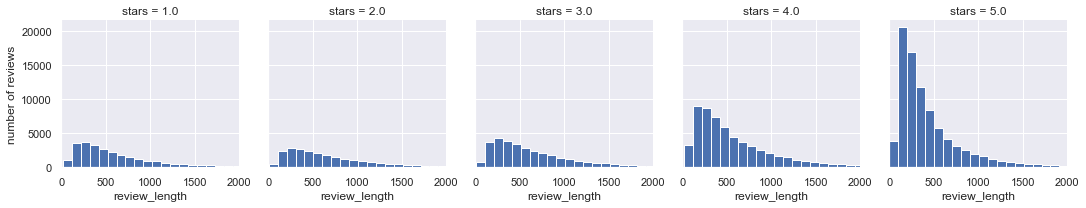

In [7]:
# check how the review lengths are distributed
reviews_df['review_length'] = reviews_df.text.map(len)

ax = sns.FacetGrid(data=reviews_df, col='stars', xlim=(0, 2000)).map(plt.hist, 'review_length', bins=50)

ax.axes[0][0].set(ylabel='number of reviews');

In [8]:
pos_reviews = reviews_df.text[reviews_df.label == 1].values
neg_reviews = reviews_df.text[reviews_df.label == -1].values
print('Postive Reviews:  {:,}'.format(len(pos_reviews)))
print('Negative Reviews:  {:,}'.format(len(neg_reviews)))

Postive Reviews:  182,678
Negative Reviews:  28,209


In [9]:
# additional stopwords
from sklearn.feature_extraction import text 
extra_words = ['ve', 'like', 'got', 'vegas','las' 'just', 
               'don', 'really', 'said', 'told', 'ok',
               'came', 'went', 'did', 'didn', 'good']
stop_words = text.ENGLISH_STOP_WORDS.union(extra_words)

In [10]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a vectorizer object to generate term document counts
tfidf_pos = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

tfidf_neg = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

# Get random subset of reviews
np.random.seed(38)
num_reviews = 20000
random_neg = np.random.choice(neg_reviews, size=num_reviews)
random_pos = np.random.choice(pos_reviews, size=num_reviews)

dicty = {'pizzas':'pizza', 'burgers':'burger', 'ordered':'order',
         'prices':'price', 'topping':'toppings'}
def replace_words(text, dicty):
    '''Returns text with word substitutions made according
       to the passed `dicty` dictionary'''
    for i,j in dicty.items():
        text = text.replace(i,j)
    return text

random_neg = [replace_words(w, dicty) for w in random_neg]
random_pos = [replace_words(w, dicty) for w in random_pos]

# Get the vectors
neg_vectors = tfidf_neg.fit_transform(random_neg)
pos_vectors = tfidf_pos.fit_transform(random_pos)

Wall time: 2.53 s


In [12]:
# Store TFIDF vectors in a Pandas DataFrame to investigate further
neg_df = pd.DataFrame(neg_vectors.todense(), columns=[tfidf_neg.get_feature_names()])
pos_df = pd.DataFrame(pos_vectors.todense(), columns=[tfidf_pos.get_feature_names()])

# get mean for each column (word): highest means are most important words
col_means_neg = {}
for col in neg_df:
    col_means_neg[col] = neg_df[col].mean()

col_means_pos = {}
for col in pos_df:
    col_means_pos[col] = pos_df[col].mean()

In [13]:
no_top_words = 10

print('Top %d words in POSITIVE reviews:' %no_top_words, end='')
print(sorted(col_means_pos, key=col_means_pos.get, reverse=True)[:no_top_words])

print('Top %d words in NEGATIVE reviews:' %no_top_words, end='')
print(sorted(col_means_neg, key=col_means_neg.get, reverse=True)[:no_top_words])

Top 10 words in POSITIVE reviews:[('great',), ('place',), ('burger',), ('service',), ('order',), ('time',), ('just',), ('chicken',), ('amazing',), ('breakfast',)]
Top 10 words in NEGATIVE reviews:[('service',), ('order',), ('place',), ('just',), ('burger',), ('time',), ('minutes',), ('bad',), ('horrible',), ('table',)]


In [14]:
# delete dataframes to save memory
del neg_df
del pos_df

In [15]:
# LSA
from gensim import corpora, models, similarities, matutils

# Convert sparse matrix of counts to a gensim corpus
# Need to transpose it for gensim which wants terms by docs instead of docs by terms
tfidf_pos_corpus = matutils.Sparse2Corpus(pos_vectors.transpose())
tfidf_neg_corpus = matutils.Sparse2Corpus(neg_vectors.transpose())

# Row indices
id2word_pos = dict((v,k) for k,v in tfidf_pos.vocabulary_.items())
id2word_neg = dict((v,k) for k,v in tfidf_neg.vocabulary_.items())

# This is a hack for Python 3!
id2word_pos = corpora.Dictionary.from_corpus(tfidf_pos_corpus, id2word=id2word_pos)
id2word_neg = corpora.Dictionary.from_corpus(tfidf_neg_corpus, id2word=id2word_neg)

C:\Users\User\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [16]:
# create LSA model
num_topics = 7
lsi_pos = models.LsiModel(tfidf_pos_corpus, id2word=id2word_pos, num_topics=num_topics)
lsi_neg = models.LsiModel(tfidf_neg_corpus, id2word=id2word_neg, num_topics=num_topics)

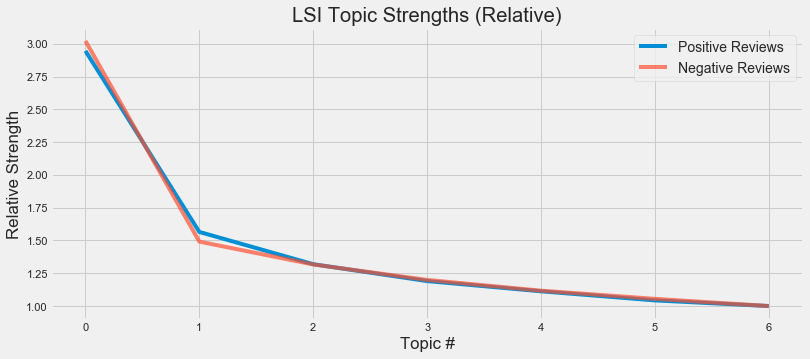

In [17]:
# elbow plot
singular_values_pos = lsi_pos.projection.s.tolist()
singular_values_pos_rel = [sv/singular_values_pos[-1] for sv in singular_values_pos]
singular_values_neg = lsi_neg.projection.s.tolist()
singular_values_neg_rel = [sv/singular_values_neg[-1] for sv in singular_values_neg]

plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,5))
plt.plot(range(len(singular_values_pos)), singular_values_pos_rel, label='Positive Reviews', alpha=1.0)
plt.plot(range(len(singular_values_neg)), singular_values_neg_rel, label='Negative Reviews', alpha=0.7)
plt.xticks(range(len(singular_values_pos)), range(len(singular_values_pos)))
plt.xlabel('Topic #')
plt.ylabel('Relative Strength')
plt.title('LSI Topic Strengths (Relative)')
plt.legend(loc=0, fontsize='medium');

In [20]:
topics_to_print = 5

In [21]:
# look at top positive topics
print('Top %d topics for POSITIVE reviews' %(topics_to_print))
print('-'*33)
pprint(lsi_pos.show_topics()[0:topics_to_print])

Top 5 topics for POSITIVE reviews
---------------------------------
[(0,
  '0.250*"great" + 0.226*"burger" + 0.214*"place" + 0.184*"service" + '
  '0.160*"order" + 0.142*"time" + 0.135*"just" + 0.129*"chicken" + '
  '0.120*"breakfast" + 0.116*"fries"'),
 (1,
  '0.786*"burger" + 0.292*"fries" + -0.205*"great" + -0.183*"breakfast" + '
  '-0.121*"service" + -0.104*"place" + 0.088*"truffle" + 0.087*"shake" + '
  '0.073*"cheese" + -0.073*"chicken"'),
 (2,
  '-0.585*"great" + 0.244*"chicken" + -0.228*"burger" + -0.217*"service" + '
  '0.199*"order" + -0.137*"amazing" + -0.137*"awesome" + -0.129*"place" + '
  '-0.126*"atmosphere" + 0.120*"fried"'),
 (3,
  '0.479*"breakfast" + -0.234*"bar" + 0.209*"pancakes" + 0.190*"eggs" + '
  '-0.172*"hour" + -0.165*"happy" + 0.162*"chicken" + -0.159*"drinks" + '
  '0.156*"burger" + 0.133*"waffles"'),
 (4,
  '-0.592*"chicken" + 0.375*"breakfast" + -0.256*"great" + -0.236*"fried" + '
  '-0.197*"waffles" + 0.162*"pancakes" + 0.147*"place" + -0.139*"salad" + '

In [22]:

# look at top negative topics
print('Top %d topics for NEGATIVE reviews' %(topics_to_print))
print('-'*33)
pprint(lsi_neg.show_topics()[0:topics_to_print])

Top 5 topics for NEGATIVE reviews
---------------------------------
[(0,
  '0.238*"order" + 0.233*"service" + 0.191*"place" + 0.173*"just" + '
  '0.168*"minutes" + 0.158*"time" + 0.152*"burger" + 0.122*"bad" + '
  '0.121*"table" + 0.117*"took"'),
 (1,
  '0.659*"burger" + 0.258*"fries" + -0.220*"minutes" + -0.171*"service" + '
  '0.127*"cheese" + -0.126*"table" + -0.122*"waited" + 0.117*"chicken" + '
  '-0.092*"server" + -0.083*"manager"'),
 (2,
  '0.529*"burger" + 0.289*"minutes" + -0.216*"chicken" + -0.202*"buffet" + '
  '-0.168*"breakfast" + -0.168*"place" + 0.158*"waited" + 0.153*"order" + '
  '0.151*"fries" + 0.117*"table"'),
 (3,
  '0.434*"service" + -0.367*"order" + -0.300*"chicken" + 0.255*"horrible" + '
  '0.217*"place" + 0.217*"burger" + 0.132*"bad" + 0.129*"terrible" + '
  '-0.124*"salad" + 0.120*"rude"'),
 (4,
  '-0.448*"service" + -0.311*"horrible" + -0.244*"chicken" + 0.214*"bar" + '
  '-0.196*"terrible" + -0.180*"order" + 0.179*"place" + -0.144*"cold" + '
  '0.134*"people

In [26]:

%%time
# negative values in LSA topics are annoying
# let's see if we can fix that with NMF
from sklearn.decomposition import NMF

# change num_topics
num_topics = 6

nmf_pos = NMF(n_components=num_topics)
W_pos = nmf_pos.fit_transform(pos_vectors)
H_pos = nmf_pos.components_

nmf_neg = NMF(n_components=num_topics)
W_neg = nmf_neg.fit_transform(neg_vectors)
H_neg = nmf_neg.components_

Wall time: 2.79 s


In [48]:
def display_topics(model, feature_names, num_topics, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        if topic_idx < num_topics:
            print("{:11}".format("Topic %d:" %(topic_idx)), end='')
            print(", ".join(['{:04.3f}*'.format(topic[i])+feature_names[i] \
                             for i in topic.argsort()[:-no_top_words-1:-1]]))

no_topics = num_topics
no_top_words = 10

print('Top topics + words for POSITIVE reviews')
print('-'*39)
display_topics(nmf_pos, tfidf_pos.get_feature_names(), no_topics, no_top_words)

print('\nTop topics + words for NEGATIVE reviews')
print('-'*39)
display_topics(nmf_neg, tfidf_neg.get_feature_names(), no_topics, no_top_words)

Top topics + words for POSITIVE reviews
---------------------------------------
Topic 0:   1.936*order, 1.680*just, 1.460*time, 1.087*bar, 1.068*pretty, 1.009*table, 0.990*restaurant, 0.947*menu, 0.931*nice, 0.860*server
Topic 1:   5.386*burger, 2.011*fries, 0.619*shake, 0.591*cheese, 0.583*truffle, 0.463*onion, 0.418*rings, 0.398*best, 0.372*shack, 0.367*sweet
Topic 2:   4.853*great, 2.073*service, 0.709*atmosphere, 0.599*excellent, 0.548*awesome, 0.458*price, 0.392*drinks, 0.392*beer, 0.374*server, 0.347*selection
Topic 3:   3.617*breakfast, 1.466*pancakes, 1.393*eggs, 0.870*toast, 0.745*coffee, 0.737*hash, 0.607*french, 0.603*potatoes, 0.569*bacon, 0.533*benedict
Topic 4:   3.747*chicken, 1.626*fried, 1.406*waffles, 0.690*salad, 0.622*cheese, 0.555*sandwich, 0.548*delicious, 0.467*sauce, 0.451*bacon, 0.431*huge
Topic 5:   2.940*place, 1.996*love, 1.899*amazing, 1.378*staff, 1.288*friendly, 0.954*best, 0.884*recommend, 0.856*definitely, 0.819*delicious, 0.767*awesome

Top topics + wo

In [31]:
# look at a random positive review
review_num = np.random.randint(0, high=len(random_pos))
print(review_num)
print(random_pos[review_num])


17357
Good food. We had a mix of breakfast and lunch - pretty standard. Their all day breakfast menu is a little small, but the breakfast buffet looked good (we missed the end of it by 10 minutes). The best part about this place was the nice service and the waitress who was pleasant and joked with us about the birds outside stealing sugar packets. Overall I was pleased with our experience just the food overall was a little meh.


In [32]:
# look at a random negative review
review_num = np.random.randint(0, high=len(random_neg))
print(review_num)
print(random_neg[review_num])


19
This is ridiculous! 20+ minutes waiting for a to go salad..... A SALAD!!!!!  There was only two orders ahead of me and I saw people behind me getting served first!


In [33]:

# compute cosine similarities of this review with all other reviews in the new space
import sklearn.metrics.pairwise as smp

cosines = {}
for ind, review in enumerate(W_pos):
    similarity = smp.cosine_similarity(W_pos[review_num].reshape(1,-1), review.reshape(1,-1))
    cosines[ind] = similarity[0][0]

In [34]:

# get top 3 matching reviews
for n in sorted(cosines, key=cosines.get, reverse=True)[1:4]:
    print('-'*50)
    print('>> Similarity {:.3f}'.format(cosines[n]))
    print(random_pos[n])
print('-'*50)

--------------------------------------------------
>> Similarity 0.999
Amazing food, with amazing service, at an affordable price! We take our family here once a week for breakfast! Love this place
--------------------------------------------------
>> Similarity 0.998
I love everything about this coffee shop. I love the food and the wide varieties of coffee!
--------------------------------------------------
>> Similarity 0.998
Good Brunch place... Crepes Omelettes pan cakes are really good, moist and traditional American. Family owned place.
--------------------------------------------------


In [35]:
from sklearn.feature_extraction.text import CountVectorizer

# Create a vectorizer object to generate term document counts
cv_pos = CountVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

cv_neg = CountVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

# Get random subset of reviews
np.random.seed(38)
num_reviews = 15000
cv_random_neg = np.random.choice(neg_reviews, size=num_reviews)
cv_random_pos = np.random.choice(pos_reviews, size=num_reviews)

# replace words from defined dictionary 'dicty'
cv_random_neg = [replace_words(w, dicty) for w in cv_random_neg]
cv_random_pos = [replace_words(w, dicty) for w in cv_random_pos]

# Get the cv vectors
cv_neg_vectors = cv_neg.fit_transform(cv_random_neg).transpose()
cv_pos_vectors = cv_pos.fit_transform(cv_random_pos).transpose()

In [36]:
# Convert sparse matrix of counts to a gensim corpus
corpus_neg = matutils.Sparse2Corpus(cv_neg_vectors)
corpus_pos = matutils.Sparse2Corpus(cv_pos_vectors)

# save a mapping (dict) of row id to word (token) for later use by gensim 
id2word_cv_pos = dict((v, k) for k, v in cv_pos.vocabulary_.items())
id2word_cv_neg = dict((v, k) for k, v in cv_neg.vocabulary_.items())

In [37]:
%%time
# create lda multicore model
lda_pos = models.ldamulticore.LdaMulticore(corpus=corpus_pos, num_topics=5, 
                                           id2word=id2word_cv_pos, passes=10, workers=15)
lda_neg = models.ldamulticore.LdaMulticore(corpus=corpus_neg, num_topics=5, 
                                           id2word=id2word_cv_neg, passes=10, workers=15)

Wall time: 2min 21s


In [38]:
print('Top topics + words for POSITIVE reviews')
print('-'*39)
pprint(lda_pos.print_topics(num_words=7))

print('\nTop topics + words for NEGATIVE reviews')
print('-'*39)
pprint(lda_neg.print_topics(num_words=7))

Top topics + words for POSITIVE reviews
---------------------------------------
[(0,
  '0.012*"burger" + 0.011*"order" + 0.009*"fries" + 0.009*"great" + '
  '0.007*"just" + 0.007*"cheese" + 0.007*"place"'),
 (1,
  '0.012*"service" + 0.011*"time" + 0.011*"just" + 0.010*"great" + '
  '0.010*"order" + 0.008*"place" + 0.007*"table"'),
 (2,
  '0.016*"breakfast" + 0.015*"order" + 0.014*"place" + 0.012*"great" + '
  '0.010*"chicken" + 0.009*"service" + 0.009*"just"'),
 (3,
  '0.023*"great" + 0.021*"place" + 0.011*"bar" + 0.011*"service" + '
  '0.008*"drinks" + 0.007*"happy" + 0.007*"nice"'),
 (4,
  '0.032*"burger" + 0.013*"place" + 0.013*"service" + 0.012*"great" + '
  '0.012*"fries" + 0.010*"just" + 0.009*"order"')]

Top topics + words for NEGATIVE reviews
---------------------------------------
[(0,
  '0.011*"service" + 0.010*"place" + 0.009*"just" + 0.009*"bar" + 0.008*"time" '
  '+ 0.008*"table" + 0.007*"rude"'),
 (1,
  '0.017*"burger" + 0.014*"place" + 0.011*"order" + 0.011*"chicken" + '

## Continuing with NMF

In [49]:
# let's remind ourselves of the POSITIVE topics
print('Top topics + words for POSITIVE reviews')
print('-'*39)
display_topics(nmf_pos, tfidf_pos.get_feature_names(), no_topics, no_top_words)

Top topics + words for POSITIVE reviews
---------------------------------------
Topic 0:   1.936*order, 1.680*just, 1.460*time, 1.087*bar, 1.068*pretty, 1.009*table, 0.990*restaurant, 0.947*menu, 0.931*nice, 0.860*server
Topic 1:   5.386*burger, 2.011*fries, 0.619*shake, 0.591*cheese, 0.583*truffle, 0.463*onion, 0.418*rings, 0.398*best, 0.372*shack, 0.367*sweet
Topic 2:   4.853*great, 2.073*service, 0.709*atmosphere, 0.599*excellent, 0.548*awesome, 0.458*price, 0.392*drinks, 0.392*beer, 0.374*server, 0.347*selection
Topic 3:   3.617*breakfast, 1.466*pancakes, 1.393*eggs, 0.870*toast, 0.745*coffee, 0.737*hash, 0.607*french, 0.603*potatoes, 0.569*bacon, 0.533*benedict
Topic 4:   3.747*chicken, 1.626*fried, 1.406*waffles, 0.690*salad, 0.622*cheese, 0.555*sandwich, 0.548*delicious, 0.467*sauce, 0.451*bacon, 0.431*huge
Topic 5:   2.940*place, 1.996*love, 1.899*amazing, 1.378*staff, 1.288*friendly, 0.954*best, 0.884*recommend, 0.856*definitely, 0.819*delicious, 0.767*awesome


In [40]:
# we can investigate a random positive review and see how it's distributed across those topics
review_num = np.random.randint(0, high=len(random_pos))
print('Positive Review #%d' %review_num)
print('-'*25)
print(random_pos[review_num])
print('-'*25)
topic_dict = {}
for ind, w in enumerate(W_pos[review_num]):
    topic_dict[ind] = w
for k in sorted(topic_dict, key=topic_dict.get, reverse=True):
     print('Topic {}: {:.4f}'.format(k, topic_dict[k]))

Positive Review #254
-------------------------
Big portion plates!
Great food!
The lounge is relaxing and their alcoholic drinks are good!
I always have to make a stop here when I'm in Vegas
-------------------------
Topic 2: 0.0372
Topic 0: 0.0113
Topic 4: 0.0037
Topic 3: 0.0003
Topic 1: 0.0000
Topic 5: 0.0000


In [50]:
print('Top topics + words for NEGATIVE reviews')
print('-'*39)
display_topics(nmf_neg, tfidf_neg.get_feature_names(), no_topics, no_top_words)

Top topics + words for NEGATIVE reviews
---------------------------------------
Topic 0:   1.835*place, 1.241*just, 1.008*bar, 0.758*time, 0.694*people, 0.559*night, 0.546*bartender, 0.540*staff, 0.528*know, 0.527*restaurant
Topic 1:   3.248*burger, 1.192*fries, 0.386*cheese, 0.349*shake, 0.221*medium, 0.194*shack, 0.192*bun, 0.190*order, 0.188*onion, 0.183*bacon
Topic 2:   1.825*minutes, 1.629*order, 1.039*table, 0.949*took, 0.924*waited, 0.862*server, 0.841*wait, 0.711*asked, 0.684*seated, 0.636*waitress
Topic 3:   1.965*chicken, 0.856*salad, 0.817*order, 0.591*sandwich, 0.515*cheese, 0.491*fried, 0.406*dry, 0.400*sauce, 0.359*steak, 0.323*wings
Topic 4:   2.616*service, 1.271*horrible, 0.879*terrible, 0.730*bad, 0.666*slow, 0.591*worst, 0.572*customer, 0.431*poor, 0.303*rude, 0.282*great
Topic 5:   1.466*breakfast, 1.301*buffet, 0.867*eggs, 0.498*price, 0.465*coffee, 0.423*pancakes, 0.411*toast, 0.395*bacon, 0.378*cold, 0.368*quality


In [42]:
# now investigate a random negative review and see how it's distributed across those topics
review_num = np.random.randint(0, high=len(random_neg))
print('Negative Review #%d' %review_num)
print('-'*25)
print(random_neg[review_num])
print('-'*25)
topic_dict = {}
for ind, w in enumerate(W_neg[review_num]):
    topic_dict[ind] = w
for k in sorted(topic_dict, key=topic_dict.get, reverse=True):
     print('Topic {}: {:.4f}'.format(k, topic_dict[k]))

Negative Review #14937
-------------------------
The most impressive thing about this restaurant is the decor. Beautifully decorated, swanky bar, eye catching touches everywhere but unfortunately, that's where it ends. Everything is else is lackluster. 

The service isn't good. They all look like they'd rather be somewhere else. Our busser was more attentive than our waiter. He never delivered the dishes or checked on our food but he popped up every 30 seconds to pick up the signed check. For these price you would think they would bring it with either service or food but the food was pretty average too. It reminds me of a high end cafe. I had a three course meal and there isn't one thing that stood out. The beet salad was blah and our apple crostata came with no ice cream and was so thick all you tasted was dough. When you're not delicate or rush pastry, it shows. I think the most disappointing part of our meal was having to eat around cigarette smokers on nearby tables (using the rest

## Topic Modeling All Reviews 
At this point, we can see that our topics are relatively interpretable and match along with the reviews they're trying to categorize. Let's proceed with topic modeling all reviews and businesses using NMF.

In [43]:
print('Postive Reviews:  {:,}'.format(len(pos_reviews)))
print('Negative Reviews:  {:,}'.format(len(neg_reviews)))

Postive Reviews:  182,678
Negative Reviews:  28,209


In [44]:
%%time
# Create a vectorizer object to generate term document counts
tfidf_pos = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

tfidf_neg = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

# replace words with defined dictionary 'dicty'
pos_reviews = [replace_words(w, dicty) for w in pos_reviews]
neg_reviews = [replace_words(w, dicty) for w in neg_reviews]

# Get the vectors
neg_vectors = tfidf_neg.fit_transform(neg_reviews)
pos_vectors = tfidf_pos.fit_transform(pos_reviews)

Wall time: 14 s


In [45]:
%%time
# NMF for all reviews
from sklearn.decomposition import NMF

# change num_topics
num_topics = 6

nmf_pos = NMF(n_components=num_topics)
W_pos = nmf_pos.fit_transform(pos_vectors)
H_pos = nmf_pos.components_

nmf_neg = NMF(n_components=num_topics)
W_neg = nmf_neg.fit_transform(neg_vectors)
H_neg = nmf_neg.components_

Wall time: 14 s


In [52]:
no_topics = num_topics
no_top_words = 10

print('Topics for POSITIVE reviews')
print('-'*39)
display_topics(nmf_pos, tfidf_pos.get_feature_names(), no_topics, no_top_words)

print('\nTopics for NEGATIVE reviews')
print('-'*39)
display_topics(nmf_neg, tfidf_neg.get_feature_names(), no_topics, no_top_words)

Topics for POSITIVE reviews
---------------------------------------
Topic 0:   1.936*order, 1.680*just, 1.460*time, 1.087*bar, 1.068*pretty, 1.009*table, 0.990*restaurant, 0.947*menu, 0.931*nice, 0.860*server
Topic 1:   5.386*burger, 2.011*fries, 0.619*shake, 0.591*cheese, 0.583*truffle, 0.463*onion, 0.418*rings, 0.398*best, 0.372*shack, 0.367*sweet
Topic 2:   4.853*great, 2.073*service, 0.709*atmosphere, 0.599*excellent, 0.548*awesome, 0.458*price, 0.392*drinks, 0.392*beer, 0.374*server, 0.347*selection
Topic 3:   3.617*breakfast, 1.466*pancakes, 1.393*eggs, 0.870*toast, 0.745*coffee, 0.737*hash, 0.607*french, 0.603*potatoes, 0.569*bacon, 0.533*benedict
Topic 4:   3.747*chicken, 1.626*fried, 1.406*waffles, 0.690*salad, 0.622*cheese, 0.555*sandwich, 0.548*delicious, 0.467*sauce, 0.451*bacon, 0.431*huge
Topic 5:   2.940*place, 1.996*love, 1.899*amazing, 1.378*staff, 1.288*friendly, 0.954*best, 0.884*recommend, 0.856*definitely, 0.819*delicious, 0.767*awesome

Topics for NEGATIVE reviews

In [72]:
# create topic dictionaries to summarize the topic meanings
pos_topics = {0:'Waiting Time', 1:'Burgers/Shakes', 2:'Customer Service', 
              3:'Breakfast/Pancakes/Eggs', 4:'Chicken/Waffles/Salad', 5:'Atmosphere'}

neg_topics = {0:'Atmosphere', 1:'Burger/Fries', 2:'Waiting Time', 
              3:'Chicken/Sandwich/Salad', 4:'Customer Service', 5:'Breakfast/Buffet/Price'}

In [80]:
print('Topic Dictionaries for POSITIVE reviews')
print('-'*39)
pos_topics



Topic Dictionaries for POSITIVE reviews
---------------------------------------


{0: 'Waiting Time',
 1: 'Burgers/Shakes',
 2: 'Customer Service',
 3: 'Breakfast/Pancakes/Eggs',
 4: 'Chicken/Waffles/Salad',
 5: 'Atmosphere'}

In [81]:
print('Topic Dictionaries for NEGATIVE reviews')
print('-'*39)
neg_topics

Topic Dictionaries for NEGATIVE reviews
---------------------------------------


{0: 'Atmosphere',
 1: 'Burger/Fries',
 2: 'Waiting Time',
 3: 'Chicken/Sandwich/Salad',
 4: 'Customer Service',
 5: 'Breakfast/Buffet/Price'}

## Adding Topic Weights to Pandas DataFrame

In [55]:
# we create dataframes for positive & negative reviews that we can
# later add topic information to
df_pos = reviews_df[['business_id', 'stars', 'text', 'review_length']][reviews_df.stars>3].reset_index()
df_neg = reviews_df[['business_id', 'stars', 'text', 'review_length']][reviews_df.stars<3].reset_index()
df_pos.drop(labels='index', axis=1, inplace=True)
df_neg.drop(labels='index', axis=1, inplace=True)

In [56]:
print('Topic weights : ', W_pos[0])
print('Sum of weights: ', W_pos[0].sum())

Topic weights :  [0.00719556 0.         0.         0.         0.00094942 0.01439414]
Sum of weights:  0.022539116548411214


In [57]:
from sklearn.preprocessing import normalize
print('Normalized Topic weights : ', normalize(W_pos[0].reshape(1,-1), norm='l1'))
print('Sum of normalized weights: ', normalize(W_pos[0].reshape(1,-1), norm='l1').sum())

Normalized Topic weights :  [[0.31924755 0.         0.         0.         0.04212326 0.63862918]]
Sum of normalized weights:  1.0


In [58]:
# add normalized topic weights to each review
df_pos = pd.concat([df_pos, pd.DataFrame(normalize(W_pos, norm='l1'))], axis=1)
df_neg = pd.concat([df_neg, pd.DataFrame(normalize(W_neg, norm='l1'))], axis=1)

In [59]:
# peek into a dataframe to ensure it worked right
df_neg.head()

,business_id,stars,text,review_length,0,1,2,3,4,5
0,jtQARsP6P-LbkyjbO1qNGg,1.0,Terrible. Dry corn bread. Rib tips were all fa...,156,0.000000,0.060127,0.000000,0.599410,0.196394,0.144069
1,faPVqws-x-5k2CQKDNtHxw,1.0,People please...the only good thing about this...,622,0.349441,0.044854,0.209831,0.323839,0.000000,0.072036
2,ZtsnwjxjzMUI6tDZNrJUeA,1.0,If there was an option to give this place nega...,734,0.614153,0.000000,0.275785,0.000000,0.110061,0.000000
3,NvKNe9DnQavC9GstglcBJQ,1.0,My friends and I went into Grand Lux Cafe at t...,580,0.058744,0.242112,0.489316,0.000000,0.209828,0.000000
4,jdAdf7keZac1idbgNKG2pw,1.0,Went with my daughter tonight and was refused ...,500,0.217431,0.762437,0.000000,0.000000,0.000000,0.020132


In [60]:
# group by business_id and apply mean/count functions to columns
df_pos_bsns = df_pos.groupby('business_id').agg({'stars':'mean', 'text':'count',
                                                 'review_length':'mean',0:'mean', 
                                                 1:'mean', 2:'mean', 3:'mean',
                                                 4:'mean', 5:'mean'}).reset_index()
df_neg_bsns = df_neg.groupby('business_id').agg({'stars':'mean', 'text':'count',
                                                 'review_length':'mean',0:'mean', 
                                                 1:'mean', 2:'mean', 3:'mean',
                                                 4:'mean', 5:'mean'}).reset_index()

In [61]:
df_pos_bsns.head()

,business_id,stars,text,review_length,0,1,2,3,4,5
0,-CQokjildrY7UZezXCdEBw,4.875000,40,743.800000,0.230307,0.098484,0.197745,0.150988,0.095735,0.226743
1,-JfncbVURtvuzBbof40o1w,4.176471,34,556.735294,0.390101,0.087458,0.155932,0.089359,0.067355,0.209795
2,-OEIW0dO96-492qa_luxaw,4.557143,210,669.052381,0.265430,0.081876,0.175936,0.134427,0.130553,0.211779
3,-PGsEXB6DFTVKa1eDOlzWA,4.660550,109,459.532110,0.253801,0.101928,0.211626,0.119228,0.097293,0.216123
4,-SGZcGqnsp_uRIjKP2RGZg,4.666667,6,343.666667,0.211774,0.016159,0.429407,0.137685,0.034168,0.170808


In [66]:
df_neg_bsns.head(50)

,business_id,stars,text,review_length,0,1,2,3,4,5
0,-CQokjildrY7UZezXCdEBw,2.000000,1,1657.000000,0.450817,0.000000,0.193718,0.118123,0.237343,0.000000
1,-JfncbVURtvuzBbof40o1w,1.430769,65,642.630769,0.255473,0.142078,0.178877,0.154595,0.151350,0.117627
2,-OEIW0dO96-492qa_luxaw,1.363636,33,841.121212,0.205873,0.137145,0.198206,0.158551,0.135997,0.164227
3,-PGsEXB6DFTVKa1eDOlzWA,1.400000,65,940.276923,0.211317,0.120797,0.191376,0.163314,0.183507,0.129690
4,-SGZcGqnsp_uRIjKP2RGZg,1.000000,3,632.000000,0.798511,0.023068,0.000000,0.000000,0.000000,0.178421
5,-U7tvCtaraTQ9b0zBhpBMA,1.562271,546,564.082418,0.272811,0.100775,0.171575,0.149064,0.185396,0.120379
6,-UtYWvCnUppcSaC_u1pTYQ,1.000000,1,158.000000,0.378945,0.021375,0.000000,0.000000,0.501256,0.098424
7,-Ylpy3VyRWwubf9dysuwjQ,1.421053,114,751.640351,0.260409,0.106774,0.155495,0.110803,0.159504,0.207016
8,-a857YYdjzgOdOjFFRsRXQ,1.315315,111,570.612613,0.271639,0.071303,0.171840,0.179159,0.151312,0.154746
9,-kbPPBNsIPDfMfgUGO7QhA,1.750000,4,693.250000,0.352562,0.019152,0.283171,0.100942,0.174495,0.069677


## Adding in Business Information 

In [73]:
# merge business name/city with topic data
df_pos_tot = df_pos_bsns.merge(restaurants_df[['business_id', 'name', 'city', 'stars']], left_on='business_id', 
                               right_on='business_id')[['business_id', 'name', 'city', 'stars_y', 0, 1, 2, 3, 4, 5]]

df_neg_tot = df_neg_bsns.merge(restaurants_df[['business_id', 'name', 'city', 'stars']], left_on='business_id', 
                               right_on='business_id')[['business_id', 'name', 'city', 'stars_y', 0, 1, 2, 3, 4, 5]]

In [74]:
# peek into business/topic distributions
df_neg_tot[df_neg_tot.name == 'Carnegie']

,business_id,name,city,stars_y,0,1,2,3,4,5
742,zU9w_xRlQSRIYXxGo-HSOA,Carnegie,Las Vegas,3.0,0.283571,0.115282,0.180055,0.150501,0.164101,0.106491


In [76]:
scores = df_pos_bsns[df_pos_bsns.business_id == 'zU9w_xRlQSRIYXxGo-HSOA'].iloc[:,-6:].values
print(restaurants_df[restaurants_df.business_id == 'zU9w_xRlQSRIYXxGo-HSOA']['name'].values[0] + ' - Positive Reviews')
print('-'*36)
for n in pos_topics:
    print('Topic {}: {:18} > {:.4f}'.format(n, pos_topics[n], scores[0][n]))

print('')
print('')
print('')
    
scores = df_neg_bsns[df_neg_bsns.business_id == 'zU9w_xRlQSRIYXxGo-HSOA'].iloc[:,-6:].values
print(restaurants_df[restaurants_df.business_id =='zU9w_xRlQSRIYXxGo-HSOA']['name'].values[0] + ' - Negative Reviews')
print('-'*36)
for n in neg_topics:
    print('Topic {}: {:18} > {:.4f}'.format(n, neg_topics[n], scores[0][n]))
    

    


Carnegie - Positive Reviews
------------------------------------
Topic 0: Waiting Time       > 0.2851
Topic 1: Burgers/Shakes     > 0.1175
Topic 2: Customer Service   > 0.1688
Topic 3: Breakfast/Pancakes/Eggs > 0.1014
Topic 4: Chicken/Waffles/Salad > 0.1067
Topic 5: Atmosphere         > 0.2206



Carnegie - Negative Reviews
------------------------------------
Topic 0: Atmosphere         > 0.2836
Topic 1: Burger/Fries       > 0.1153
Topic 2: Waiting Time       > 0.1801
Topic 3: Chicken/Sandwich/Salad > 0.1505
Topic 4: Customer Service   > 0.1641
Topic 5: Breakfast/Buffet/Price > 0.1065


In [77]:
%%time
# write to CSV
df_pos_tot.to_csv('datasets/pos_bsns.csv')
df_neg_tot.to_csv('datasets/neg_bsns.csv')
df_pos.to_csv('datasets/pos_reviews.csv')
df_neg.to_csv('datasets/neg_reviews.csv')

Wall time: 5.91 s
